In [399]:
import numpy as np
import matplotlib.pyplot as plt
import pmagpy.pmag as pmag
import pandas as pd
import scipy as sci
from scipy import interpolate
import seaborn as sns

## Files Needed:
- Paleomag_database.xlsx
- ERA40lat
- ERA40lon
- meanT
- meanP
- Onx3HeT 
- Sinx3HeT 
- Fenx3HeT
- Canx3HeT
- Mgnx3HeT
- Alnx3HeT
- a_values
- b_values
- basic_spectrum
- c_values
- ground_level_spectrum
- thermal_neutron_spectrum
- basic_spectrum_protons
- primary_spectrum
- secondary_spectrum 
- h_values_protons
- Opx3HeT
- Sipx3HeT
- Fepx3HeT
- Capx3HeT
- Mgpx3HeT
- Alpx3HeT

## User Inputs

In [400]:
SiteHe_qtz = []
SiteHe_cpx = []
SiteHe_ol = []

In [401]:
site_lat = 40
site_lon = 50 #correct for negative longitudes in ERA40 analysis
therm = False #does the user want the therm criteria (specified paleomag data)? Used in paleomag section
altitude = 0 #user input, in meters above sea level, for pressure correction. Used in pressure section
stdatm = 1 #user inputs 1 for standard, 0 for ERA40. Used in pressure section
w = 0.06; # water content, from 0-1. Used in production rates calculation. 0.06 is standard, see LSD.
system = 1 #1 for qtz, 2 for cpx, 3 for olivine. Used in production rates calculation
system_b = 0 #1 = enstatite, 2 = ferrosilite, 3 = wollastonite, 4 = augite. Put 0 if using qtz or ol
system_c = 0 #1 = forsterite, 2 = fayalite, 3 = f8?. Put 0 if using qtz or cpx

## Paleointensity Section
- Cell 1: import custom paleomag (IAGA + Geomagia) database. Need excel file for this to run. Compiled by Katie Bristol
- Cell 2: generates paleolatitude (variational) vector
- Cell 3: Code will drop any data points beyond 70 Ma.
    - This cell also includes any criteria specifications
    - NOTE: if you change therm from true to false, have to run notebook from beginning. 
- Cell 5: assigns bin_names in 5 myr increments to the dataset. 
- Cell 6: calculates mean VDM's for each 5 Myr bin, while also printing out how many datapoints were used to calculate this mean.

In [402]:
#CELL 1
Paleomag_database = pd.read_excel('Paleomag_database.xlsx') #excel sheet with all pmag data. 0-70 Ma, all criteria

In [403]:
#CELL 2
time = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70] #will report paleolatitude values from 0-70 Million years ago, in 5 Myr increments 
vals = [] #storage for pmagpy data 
for i in time:
    data=['NA',site_lat, site_lon,i] #specify plate, lat/lon that was input above
    #plate : [NA, SA, AF, IN, EU, AU, ANT, GL]
                #NA : North America
                #SA : South America
                #AF : Africa
                #IN : India
                #EU : Eurasia
                #AU : Australia
                #ANT: Antarctica
                #GL : Greenland
    pmag.apwp(data, print_results = False) #change to true if you want to see the output
    vals.append(pmag.apwp(data))

df = pd.DataFrame(vals) #create a dataframe with the pmagpy data
df.columns = ['Age', 'Paleolat', 'Dec','Inc','Pole_lat','Pole_Long'] #rename the columns
Paleolat = df['Paleolat'] #call paleolat whenever you want all the paleolatitudes for some time frame

In [404]:
#CELL 3
age_range = np.arange(0,70) #will remove data points beyond 70 Ma from paleomag database. 
Paleomag_database.drop(Paleomag_database[Paleomag_database['AGE'] < age_range[0]].index, inplace = True) 
Paleomag_database.drop(Paleomag_database[Paleomag_database['AGE'] > age_range[-1]].index, inplace = True)

#Criteria evaluation
pd.set_option("display.max_rows", None, "display.max_columns", None) 

#here, the user will input what sort of criteria they want on the paleomag data used to calculate Rc
#True = therm parameters
#Note: weird spacing in title headers because of how Geomagia/IAGA databases are imported into excel file.
#If user imports excel file correctly, these lines should work properly. 
HeZ = Paleomag_database[Paleomag_database['IntM'] == '   HeZ       ' ].index
LTD_DHT_S = Paleomag_database[Paleomag_database['IntM'] == '   LTD-DHT-S ' ].index
M = Paleomag_database[Paleomag_database['IntM'] == '   M         ' ].index
MSPDp = Paleomag_database[Paleomag_database['IntM'] == '   MSPDp     ' ].index
ONR = Paleomag_database[Paleomag_database['IntM'] == '   ONR       ' ].index
S = Paleomag_database[Paleomag_database['IntM'] == '   S         ' ].index
ST = Paleomag_database[Paleomag_database['IntM'] == '   ST        ' ].index
SW = Paleomag_database[Paleomag_database['IntM'] == '   SW        ' ].index
TZ = Paleomag_database[Paleomag_database['IntM'] == '   TZ        ' ].index
Tminus = Paleomag_database[Paleomag_database['IntM'] == '   T-        ' ].index
W = Paleomag_database[Paleomag_database['IntM'] == '   W         ' ].index
WB = Paleomag_database[Paleomag_database['IntM'] == '   WB        ' ].index
WZ = Paleomag_database[Paleomag_database['IntM'] == '   WZ        ' ].index
Z = Paleomag_database[Paleomag_database['IntM'] == '   Z         ' ].index
Tv = Paleomag_database[Paleomag_database['IntM'] == '   Tv        ' ].index

if therm == True: #therm criteria, default is false.
    #the following lines index string values (criteria from excel sheet). 
    Paleomag_database.drop(HeZ, inplace=True)
    Paleomag_database.drop(LTD_DHT_S, inplace=True)
    Paleomag_database.drop(M, inplace=True)
    Paleomag_database.drop(MSPDp, inplace=True)
    Paleomag_database.drop(ONR, inplace=True)
    Paleomag_database.drop(S, inplace=True)
    Paleomag_database.drop(ST, inplace=True)
    Paleomag_database.drop(SW, inplace=True)
    Paleomag_database.drop(TZ, inplace=True)
    Paleomag_database.drop(Tv, inplace=True)
    Paleomag_database.drop(Tminus, inplace=True)
    Paleomag_database.drop(W, inplace=True)
    Paleomag_database.drop(WB, inplace=True)
    Paleomag_database.drop(WZ, inplace=True)
    Paleomag_database.drop(Z, inplace=True)

In [405]:
#CELL 5: Binning data for 5 Myr sets
bin_1 = Paleomag_database[Paleomag_database['AGE'] <= 0.05]
bin_2 = Paleomag_database[(Paleomag_database['AGE'] <= 5) & (Paleomag_database['AGE'] > 0.05)]
bin_3 = Paleomag_database[(Paleomag_database['AGE'] <= 10) & (Paleomag_database['AGE'] > 5)]
bin_4 = Paleomag_database[(Paleomag_database['AGE'] <= 15) & (Paleomag_database['AGE'] > 10)]
bin_5 = Paleomag_database[(Paleomag_database['AGE'] <= 20) & (Paleomag_database['AGE'] > 15)]
bin_6 = Paleomag_database[(Paleomag_database['AGE'] <= 25) & (Paleomag_database['AGE'] > 20)]
bin_7 = Paleomag_database[(Paleomag_database['AGE'] <= 30) & (Paleomag_database['AGE'] > 25)]
bin_8 = Paleomag_database[(Paleomag_database['AGE'] <= 35) & (Paleomag_database['AGE'] > 30)]
bin_9 = Paleomag_database[(Paleomag_database['AGE'] <= 40) & (Paleomag_database['AGE'] > 35)]
bin_10 = Paleomag_database[(Paleomag_database['AGE'] <= 45) & (Paleomag_database['AGE'] > 40)]
bin_11 = Paleomag_database[(Paleomag_database['AGE'] <= 50) & (Paleomag_database['AGE'] > 45)]
bin_12 = Paleomag_database[(Paleomag_database['AGE'] <= 55) & (Paleomag_database['AGE'] > 50)]
bin_13 = Paleomag_database[(Paleomag_database['AGE'] <= 60) & (Paleomag_database['AGE'] > 55)]
bin_14 = Paleomag_database[(Paleomag_database['AGE'] <= 65) & (Paleomag_database['AGE'] > 60)]
bin_15 = Paleomag_database[(Paleomag_database['AGE'] <= 70) & (Paleomag_database['AGE'] > 65)]

In [406]:
#CELL 6
means = []
median = []
bin_1 = bin_1[pd.to_numeric(bin_1['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_1['VDM'] = bin_1['VDM'].astype(float)
means.append((bin_1["VDM"].mean()))#calculates mean
median.append(bin_1['VDM'].median())
index_1 = bin_1.index
n_1 = len(index_1)
#print('The number of data points from present to 0.05 Ma is', n_1)

bin_2 = bin_2[pd.to_numeric(bin_2['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_2['VDM'] = bin_2['VDM'].astype(float)
means.append((bin_2["VDM"].mean()))#calculates mean
median.append(bin_2['VDM'].median())
index_2 = bin_2.index
n_2 = len(index_2)
#print('The number of data points from 0.05 to 5 Ma is', n_2)

bin_3 = bin_3[pd.to_numeric(bin_3['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_3['VDM'] = bin_3['VDM'].astype(float)
means.append((bin_3["VDM"].mean()))#calculates mean
median.append(bin_3['VDM'].median())
index_3 = bin_3.index
n_3 = len(index_3)
#print('The number of data points from 5 to 10 Ma is', n_3)

bin_4 = bin_4[pd.to_numeric(bin_4['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_4['VDM'] = bin_4['VDM'].astype(float)
means.append((bin_4["VDM"].mean()))#calculates mean
median.append(bin_4['VDM'].median())
index_4 = bin_4.index
n_4 = len(index_4)
#print('The number of data points from 10 to 15 Ma is', n_4)

bin_5 = bin_5[pd.to_numeric(bin_5['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_5['VDM'] = bin_5['VDM'].astype(float)
means.append((bin_5["VDM"].mean()))#calculates mean
median.append(bin_5['VDM'].median())
index_5 = bin_5.index
n_5 = len(index_5)
#print('The number of data points from 15 to 20 Ma is', n_5)

bin_6 = bin_6[pd.to_numeric(bin_6['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_6['VDM'] = bin_6['VDM'].astype(float)
means.append((bin_6["VDM"].mean()))#calculates mean
median.append(bin_6['VDM'].median())
index_6 = bin_6.index
n_6 = len(index_6)
#print('The number of data points from 20 to 25 Ma is', n_6)

bin_7 = bin_7[pd.to_numeric(bin_7['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_7['VDM'] = bin_7['VDM'].astype(float)
means.append((bin_7["VDM"].mean()))#calculates mean
median.append(bin_7['VDM'].median())
index_7 = bin_7.index
n_7 = len(index_7)
#print('The number of data points from 25 to 30 Ma is', n_7)

bin_8 = bin_8[pd.to_numeric(bin_8['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_8['VDM'] = bin_8['VDM'].astype(float)
means.append((bin_8["VDM"].mean()))#calculates mean
median.append(bin_8['VDM'].median())
index_8 = bin_8.index
n_8 = len(index_8)
#print('The number of data points from 30 to 35 Ma is', n_8)

bin_9 = bin_9[pd.to_numeric(bin_9['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_9['VDM'] = bin_9['VDM'].astype(float)
means.append((bin_9["VDM"].mean()))#calculates mean
median.append(bin_9['VDM'].median())
index_9 = bin_9.index
n_9 = len(index_9)
#print('The number of data points from 35 to 40 Ma is', n_9)

bin_10 = bin_10[pd.to_numeric(bin_10['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_10['VDM'] = bin_10['VDM'].astype(float)
means.append((bin_10["VDM"].mean()))#calculates mean
median.append(bin_10['VDM'].median())
index_10 = bin_10.index
n_10 = len(index_10)
#print('The number of data points from 40 to 45 Ma is', n_10)

bin_11 = bin_11[pd.to_numeric(bin_11['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_11['VDM'] = bin_11['VDM'].astype(float)
means.append((bin_11["VDM"].mean()))#calculates mean
median.append(bin_11['VDM'].median())
index_11 = bin_11.index
n_11 = len(index_11)
#print('The number of data points from 45 to 50 Ma is', n_11)

bin_12 = bin_12[pd.to_numeric(bin_12['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_12['VDM'] = bin_12['VDM'].astype(float)
means.append((bin_12["VDM"].mean()))#calculates mean
median.append(bin_12['VDM'].median())
index_12 = bin_12.index
n_12 = len(index_12)
#print('The number of data points from 50 to 55 Ma is', n_12)

bin_13 = bin_13[pd.to_numeric(bin_13['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_13['VDM'] = bin_13['VDM'].astype(float)
means.append((bin_13["VDM"].mean()))#calculates mean
median.append(bin_13['VDM'].median())
index_13 = bin_13.index
n_13 = len(index_13)
#print('The number of data points from 55 to 60 Ma is', n_13)

bin_14 = bin_14[pd.to_numeric(bin_14['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_14['VDM'] = bin_14['VDM'].astype(float)
means.append((bin_14["VDM"].mean()))#calculates mean
median.append(bin_14['VDM'].median())
index_14 = bin_14.index
n_14 = len(index_14)
#print('The number of data points from 60 to 65 Ma is', n_14)

bin_15 = bin_15[pd.to_numeric(bin_15['VDM'], errors='coerce').notnull()] #dropping the &nbsp vals  
bin_15['VDM'] = bin_15['VDM'].astype(float)
means.append((bin_15["VDM"].mean()))#calculates mean
median.append(bin_15['VDM'].median())
index_15 = bin_15.index
n_15 = len(index_15)
#print('The number of data points from 65 to 70 Ma is', n_15)

## Cutoff Rigidty (Rc) Calculation
- Based on 6th order polynomial from Lifton (2014) 


In [407]:
M0 = 7.95 #[*10^22 Am^2] constant, magnetic moment today for reference field.
Rc = [] #will store Rc values
temp = [] #will store relative intensity values
for i in range(len(means)): 
    Rc_calc = (means[i]/M0)*(6.89901*np.cos(np.deg2rad(Paleolat[i])) - 103.241*(np.cos(np.deg2rad(Paleolat[i])))**2 + 522.061*(np.cos(np.deg2rad(Paleolat[i])))**3 - 1152.15*(np.cos(np.deg2rad(Paleolat[i])))**4 + 1189.18*(np.cos(np.deg2rad(Paleolat[i])))**5 - 448.004*(np.cos(np.deg2rad(Paleolat[i])))**6)  #from Lifton (2014)
    Rc.append(Rc_calc)
    temp.append(means[i]/M0)

## Reading Files
- reads all the relevant files needed to run subsequent cells

In [408]:
ERA40lat = pd.read_csv('ERA40lat', header=None)
ERA40lon = pd.read_csv('ERA40lon', header=None)
meanT = pd.read_csv('meanT', header=None)
meanP = pd.read_csv('meanP', header=None) 

Onx3HeT = pd.read_csv('Onx3HeT', header = None)
Sinx3HeT = pd.read_csv('Sinx3HeT', header=None) #Same as above
Fenx3HeT = pd.read_csv('Fenx3HeT', header=None)
Canx3HeT = pd.read_csv('Canx3HeT', header=None)
Mgnx3HeT = pd.read_csv('Mgnx3HeT', header=None)
Alnx3HeT = pd.read_csv('Alnx3HeT', header=None)
a_values = pd.read_csv('a_values', header=None)
b_values = pd.read_csv('b_values', header=None)
basic_spectrum = pd.read_csv('basic_spectrum',header=None)
c_values = pd.read_csv('c_values', header=None)
ground_level_spectrum = pd.read_csv('ground_level_spectrum',header=None)
thermal_neutron_spectrum = pd.read_csv('thermal_neutron_spectrum',header=None)

#FOR PROTONS:
basic_spectrum_protons = pd.read_csv('basic_spectrum_protons', header = None)
primary_spectrum = pd.read_csv('primary_spectrum', header = None)
secondary_spectrum = pd.read_csv('secondary_spectrum', header = None)
h_values_protons = pd.read_csv('h_values_protons', header = None)
basic_spectrum_protons.columns = ['variable','values']
primary_spectrum.columns = ['variable','values']
secondary_spectrum.columns = ['variable','values']
h_values_protons.columns = ['variable','values']

Opx3HeT = pd.read_csv('Opx3HeT', header = None)
Sipx3HeT = pd.read_csv('Sipx3HeT', header = None)
Fepx3HeT = pd.read_csv('Fepx3HeT', header=None)
Capx3HeT = pd.read_csv('Capx3HeT', header=None)
Mgpx3HeT = pd.read_csv('Mgpx3HeT', header=None)
Alpx3HeT = pd.read_csv('Alpx3HeT', header=None)

## Pressure Corrections
- Reads in ERA40 reanalysis data (imports text files, retrieved from LSD code)
    - then uses 2D interpolation to determine a site_pressure
    - uses user input of site_lat, site_lon, and altitude
    - the ERA40 reanalysis will run if the user specifies at the beginning that stdatm = 0
    - if not, it will run a standard atmospheric equation instead to assign a site_pressure for the p-rate code.

In [409]:
lat_numpy = ERA40lat.to_numpy()
lon_numpy = ERA40lon.to_numpy()
meanT_numpy = meanT.to_numpy()
meanP_numpy = meanP.to_numpy()
gmr = -0.03417; # Assorted constants
dtdz = 0.0065; # Lapse rate from standard atmosphere

if site_lon < 0: #negative longitude correction
    site_lon = site_lon + 360
t = sci.interpolate.interp2d(lon_numpy,lat_numpy,meanT_numpy)
site_T = t(site_lat, site_lon)
site_T_degK = site_T + 273.15
p = sci.interpolate.interp2d(lon_numpy,lat_numpy,meanP_numpy)
site_slp = p(site_lat, site_lon)

#Lifton Lapse Rate Fit to COSPAR CIRA-86 <10 km altitude

lr = [-6.1517E-03, -3.1831E-06, -1.5014E-07, 1.8097E-09, 1.1791E-10, -6.5359E-14, -9.5209E-15]

dtdz = lr[0] + lr[1]*site_lat + lr[2]*site_lat**2 + lr[3]*site_lat**3 + lr[4]*site_lat**4 + lr[5]*site_lat**5 + lr[6]*site_lat**6;
dtdz = -dtdz

# Calculate site pressure using the site-specific SLP and T1000 with the
# standard atmosphere equation.

if stdatm == 0: #ERA40
    sample_pressure = site_slp * np.exp( (gmr/dtdz) * (np.log(site_T) - np.log(site_T - (altitude*dtdz)) ) )
    sample_pressure = float(sample_pressure)
else: #standard
    sample_pressure = 1013.25 * np.exp((gmr/dtdz)*(np.log(288.15) - np.log(288.15 - (altitude*dtdz))))
#sample_pressure

## Production Rates Calculation
- Cell 1: renames columns in relevant text files, defines energy spectrum (E) as defined in LSD
- Cell 2: Essentially LSD code (Neutrons.m) converted to Python
    - Computes production rate of 3He in either qtz, cpx, or olivine 
    - will determine which scheme to use based on user input of system = 1, 2, or 3. 
    - "p3n" will return the production rate for each 5 Myr bin from neutron spallation
- Cell 3: p3p does same, but proton production

In [410]:
#Assign column names to text files
a_values.columns = ['variable','values']
b_values.columns = ['variable','values']
basic_spectrum.columns = ['variable', 'values']
c_values.columns = ['variable', 'values']
ground_level_spectrum.columns = ['variable' , 'values']
thermal_neutron_spectrum.columns = ['variable' , 'values']
df = np.logspace(0,5.3010,200) #Energy spectrum [MeV]. From LSD, data from Sato & Nita (2008) 
E = pd.DataFrame(df)
E.columns = ['Energy']

In [411]:
PhiL_list = []
p3n = []
p3n_cpx = []
p3n_ol = []
p3n_qtz = []
# Energy spectrum [MeV]. From Sato & Nita (2006 or 2008, one has neutrons one has protons)
s = 465; #Solar modulation- uses constant value that Lifton (2008)/code uses for samples beyond 10 Ma
x = sample_pressure*1.019716 #sample pressure converted from user input of elevation, calculated in above cells
Et = 2.5e-8; #Thermal neutron energy in MeV
## Integrated neutron flux <15 MeV

smin = 400; #Units of MV
smax = 1200; #Units of MV

# Ground-Level Spectrum
g3 = 10**(ground_level_spectrum.iloc[0]['values'] + (ground_level_spectrum.iloc[1]['values'])/(w + ground_level_spectrum.iloc[2]['values']))
g5 = ground_level_spectrum.iloc[3]['values'] + (ground_level_spectrum.iloc[4]['values']*w) + ground_level_spectrum.iloc[5]['values']*(w**2);
fG = 10**(ground_level_spectrum.iloc[6]['values'] + ground_level_spectrum.iloc[7]['values']*np.log10(E/g3)*(1-np.tanh(ground_level_spectrum.iloc[8]['values']*np.log10(E/g5))))

# Thermal Neutron Spectrum
g6 = (thermal_neutron_spectrum.iloc[0]['values'] + thermal_neutron_spectrum.iloc[1]['values']*np.exp(-thermal_neutron_spectrum.iloc[2]['values']*w))/(1 + thermal_neutron_spectrum.iloc[3]['values']*np.exp(-thermal_neutron_spectrum.iloc[4]['values']*w))

PhiT = g6*((E/Et)**2)*np.exp(-E/Et)

# Total Ground-Level Flux

PhiB = np.zeros((1,len(E)))
PhiG = np.zeros((1,len(E)))
PhiGMev = np.zeros((1,len(E)))
p3n_temp = np.zeros((1,len(E)))

for a in range(len(Rc)):
    a1min = b_values.iloc[0]['values'] + b_values.iloc[2]['values']*Rc[a] + b_values.iloc[4]['values']/(1 + np.exp((Rc[a] - b_values.iloc[6]['values'])/b_values.iloc[8]['values']))
    a1max = b_values.iloc[1]['values'] + b_values.iloc[3]['values']*Rc[a] + b_values.iloc[5]['values']/(1 + np.exp((Rc[a] - b_values.iloc[7]['values'])/b_values.iloc[9]['values']))
    a2min = b_values.iloc[10]['values'] + b_values.iloc[12]['values']*Rc[a] + b_values.iloc[14]['values']/(1 + np.exp((Rc[a] - b_values.iloc[16]['values'])/b_values.iloc[18]['values']))
    a2max = b_values.iloc[11]['values'] + b_values.iloc[13]['values']*Rc[a] + b_values.iloc[15]['values']/(1 + np.exp((Rc[a] - b_values.iloc[17]['values'])/b_values.iloc[19]['values']))
    a3min = b_values.iloc[20]['values'] + b_values.iloc[22]['values']*Rc[a] + b_values.iloc[24]['values']/(1 + np.exp((Rc[a] - b_values.iloc[26]['values'])/b_values.iloc[28]['values']))
    a3max = b_values.iloc[21]['values'] + b_values.iloc[23]['values']*Rc[a] + b_values.iloc[25]['values']/(1 + np.exp((Rc[a] - b_values.iloc[27]['values'])/b_values.iloc[29]['values']))
    a4min = b_values.iloc[30]['values'] + b_values.iloc[32]['values']*Rc[a] + b_values.iloc[34]['values']/(1 + np.exp((Rc[a] - b_values.iloc[36]['values'])/b_values.iloc[38]['values']))
    a4max = b_values.iloc[31]['values'] + b_values.iloc[33]['values']*Rc[a] + b_values.iloc[35]['values']/(1 + np.exp((Rc[a] - b_values.iloc[37]['values'])/b_values.iloc[39]['values']))

    a5 = basic_spectrum.iloc[0]['values'] + basic_spectrum.iloc[1]['values']*Rc[a] + basic_spectrum.iloc[2]['values']/(1 + np.exp((Rc[a] - basic_spectrum.iloc[3]['values'])/basic_spectrum.iloc[4]['values']))
    a9 = basic_spectrum.iloc[5]['values'] + basic_spectrum.iloc[6]['values']*Rc[a] + basic_spectrum.iloc[7]['values']/(1 + np.exp((Rc[a] - basic_spectrum.iloc[8]['values'])/basic_spectrum.iloc[9]['values']));
    a10 = basic_spectrum.iloc[10]['values'] + basic_spectrum.iloc[11]['values']*Rc[a] + basic_spectrum.iloc[12]['values']/(1 + np.exp((Rc[a] - basic_spectrum.iloc[13]['values'])/basic_spectrum.iloc[14]['values']));
    a11 = basic_spectrum.iloc[15]['values'] + basic_spectrum.iloc[16]['values']*Rc[a] + basic_spectrum.iloc[17]['values']/(1 + np.exp((Rc[a] - basic_spectrum.iloc[18]['values'])/basic_spectrum.iloc[19]['values']));

    b5 = b_values.iloc[40]['values'] + b_values.iloc[41]['values']*Rc[a] + b_values.iloc[42]['values']/(1 + np.exp((Rc[a] - b_values.iloc[43]['values'])/b_values.iloc[44]['values']))
    b6 = b_values.iloc[45]['values'] + b_values.iloc[46]['values']*Rc[a] + b_values.iloc[47]['values']/(1 + np.exp((Rc[a] - b_values.iloc[48]['values'])/b_values.iloc[49]['values']))
    c4 = a5 + a_values.iloc[0]['values']*x/(1 + a_values.iloc[1]['values']*np.exp(a_values.iloc[2]['values']*x)) #lethargy^-1
    c12 = a9*(np.exp(-a10*x) + a11*np.exp(-a_values.iloc[3]['values']*x)) # MeV

    PhiLmin = a1min*(np.exp(-a2min*x) - a3min*np.exp(-a4min*x)) #Length of Rc
    PhiLmax = a1max*(np.exp(-a2max*x) - a3max*np.exp(-a4max*x)) #Length of Rc
    f3 = b5 + (b6*x)
    f2 = (PhiLmin - PhiLmax)/(smin**f3 - smax**f3)
    f1 = PhiLmin - f2*smin**f3;
    
    PhiL = f1 + (f2*s**f3)
    PhiL_list.append(PhiL)
    
    PhiB = (c_values.iloc[0]['values']*(E/c_values.iloc[1]['values'])**c_values.iloc[2]['values'])*np.exp(-E/c_values.iloc[1]['values']) + c4*np.exp((-(np.log10(E) - np.log10(c_values.iloc[3]['values']))**2)/(2*(np.log10(c_values.iloc[4]['values']))**2)) + c_values.iloc[5]['values']*np.log10(E/c_values.iloc[6]['values'])*(1 + np.tanh(c_values.iloc[7]['values']*np.log10(E/c_values.iloc[8]['values'])))*(1 - np.tanh(c_values.iloc[9]['values']*np.log10(E/c12)))

for i in range(len(Rc)):
    PhiG = PhiL_list[i]*(PhiB*fG + PhiT)
    df2 = PhiG/E
    PhiGMev = pd.DataFrame(df2)
    a = PhiGMev.to_numpy()
    b = E.to_numpy()
    c = Onx3HeT.to_numpy()
    d = Sinx3HeT.to_numpy()
    e = Fenx3HeT.to_numpy()
    f = Canx3HeT.to_numpy()
    g = Mgnx3HeT.to_numpy()
    h = Alnx3HeT.to_numpy()
    PhiGMev_array = np.reshape(a, 200)
    E_array = np.reshape(b, 200)
    Onx3HeT_array = np.reshape(c,200)
    Sinx3HeT_array = np.reshape(d,200)
    Fenx3HeT_array = np.reshape(e,200)
    Canx3HeT_array = np.reshape(f,200)
    Mgnx3HeT_array = np.reshape(g,200)
    Alnx3HeT_array = np.reshape(h,200)

    #Quartz
    if system == 1: #qtz
        p3n_temp_qtz = (np.trapz(PhiGMev_array*Onx3HeT_array,E_array) + np.trapz(PhiGMev_array*(Sinx3HeT_array/2), E_array))*(2.00600000000000e22*1e-27*3.1536e7)
        p3n_qtz.append(p3n_temp_qtz)
    #Inserted from Dave Parmelee's code (MS thesis, NMT 2014) to account for composition
    #dependence of clinopyroxene
    if system == 2: #cpx
        p3n_temp_cpx = (np.trapz(PhiGMev_array*Onx3HeT_array, E_array) +
        np.trapz(PhiGMev_array*(Sinx3HeT_array*(1.92/6)),E_array) +
        np.trapz(PhiGMev_array*(Alnx3HeT_array*(0.12/6)),E_array) +
        np.trapz(PhiGMev_array*(Mgnx3HeT_array*(0.67/6)), E_array) +
        np.trapz(PhiGMev_array*(Fenx3HeT_array*(0.31/6)), E_array) +
        np.trapz(PhiGMev_array*(Canx3HeT_array*(0.86/6)), E_array))*(2.00600000000000e22*1e-27*3.1536e7)
        p3n_cpx.append(p3n_temp_cpx)
    if system == 3: #olivine
        p3n_temp_ol = (np.trapz(PhiGMev_array*Onx3HeT_array, E_array) +
        np.trapz(PhiGMev_array*(Sinx3HeT_array*(1/4)), E_array) + 
        np.trapz(PhiGMev_array*(Mgnx3HeT_array*(1.1/4)), E_array) +
        np.trapz(PhiGMev_array*(Fenx3HeT_array*(0.9/4)), E_array))*(2.00600000000000e22*1e-27*3.1536e7)
        p3n_ol.append(p3n_temp_ol)
p3n_ol

[]

In [412]:
#PROTONS
p3p_cpx = []
p3p_ol = []
p3p_qtz = []
A = 1
Z = 1
Ep = 938.27 #Rest mass of a proton
U = (4-1.675)*(np.pi)*(A/Z)*1e-7 # Unit conversion factor
p3p = []
s = 465
x = sample_pressure*1.01976

#Primary spectrum
Etoa = E + primary_spectrum.iloc[0]['values']*x
Rtoa = 0.001*np.sqrt((A*Etoa)**2 + 2*A*Ep*Etoa)/Z
#Rc = Rc_const
Elis = np.zeros((1,len(E)))
Beta = np.zeros((1,len(E)))
Rlis =np.zeros((1,len(E)))
phiTOA = np.zeros((1,len(E)))
phiLIS = np.zeros((1,len(E)))
phiSec = np.zeros((1,len(E)))
phiPtot = np.zeros((1,len(E)))
p10p = np.zeros((1,len(E)))

b1 = secondary_spectrum.iloc[0]['values'] + secondary_spectrum.iloc[1]['values']*x + secondary_spectrum.iloc[2]['values']*x**2 + secondary_spectrum.iloc[3]['values']*x**3
b2 = secondary_spectrum.iloc[4]['values'] + secondary_spectrum.iloc[5]['values']*x + secondary_spectrum.iloc[6]['values']*x**2 + secondary_spectrum.iloc[7]['values']*x**3
b3 = secondary_spectrum.iloc[8]['values'] + secondary_spectrum.iloc[9]['values']*x + secondary_spectrum.iloc[10]['values']*x**2 + secondary_spectrum.iloc[11]['values']*x**3
b4 = secondary_spectrum.iloc[12]['values'] + secondary_spectrum.iloc[13]['values']*x + secondary_spectrum.iloc[14]['values']*x**2 + secondary_spectrum.iloc[15]['values']*x**3


#Combine primary and secondary spectra

for a in range(len(Rc)):
    cp = Opx3HeT.to_numpy()
    dp = Sipx3HeT.to_numpy()
    Opx3HeT_array = np.reshape(cp,200)
    Sipx3HeT_array = np.reshape(dp,200)
   
    Elis = Etoa + s*Z/A
    Beta = np.sqrt(1-(Ep/(Ep + Elis*A))**2) # Particle speed relative to light
    Rlis = 0.001*np.sqrt((A*Elis)**2 + 2*A*Ep*Elis)/Z
    C = primary_spectrum.iloc[6]['values'] + primary_spectrum.iloc[7]['values']/(1 + np.exp((Elis - primary_spectrum.iloc[8]['values'])/primary_spectrum.iloc[9]['values']))
    phiTOA = (C*(Beta**primary_spectrum.iloc[4]['values'])/(Rlis**primary_spectrum.iloc[5]['values']))*(Rtoa/Rlis)**2
    phiPri = (U/Beta)*phiTOA*(primary_spectrum.iloc[1]['values']*np.exp(-primary_spectrum.iloc[2]['values']*x) + (1 - primary_spectrum.iloc[1]['values'])*np.exp(-primary_spectrum.iloc[3]['values']*x))
    
    g1min = h_values_protons.iloc[0]['values'] + h_values_protons.iloc[2]['values']*Rc[a] + h_values_protons.iloc[4]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[6]['values'])/h_values_protons.iloc[8]['values']))
    g1max = h_values_protons.iloc[1]['values'] + h_values_protons.iloc[3]['values']*Rc[a] + h_values_protons.iloc[5]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[7]['values'])/h_values_protons.iloc[9]['values']))
    g2min = h_values_protons.iloc[10]['values'] + h_values_protons.iloc[12]['values']*Rc[a] + h_values_protons.iloc[14]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[16]['values'])/h_values_protons.iloc[18]['values']))
    g2max = h_values_protons.iloc[11]['values'] + h_values_protons.iloc[13]['values']*Rc[a] + h_values_protons.iloc[15]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[17]['values'])/h_values_protons.iloc[19]['values']))
    g3min = h_values_protons.iloc[20]['values'] + h_values_protons.iloc[22]['values']*Rc[a] + h_values_protons.iloc[24]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[26]['values'])/h_values_protons.iloc[28]['values']))
    g3max = h_values_protons.iloc[21]['values'] + h_values_protons.iloc[23]['values']*Rc[a] + h_values_protons.iloc[25]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[27]['values'])/h_values_protons.iloc[29]['values']))
    g4min = h_values_protons.iloc[30]['values'] + h_values_protons.iloc[32]['values']*Rc[a] + h_values_protons.iloc[34]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[36]['values'])/h_values_protons.iloc[38]['values']))
    g4max = h_values_protons.iloc[31]['values'] + h_values_protons.iloc[33]['values']*Rc[a] + h_values_protons.iloc[35]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[37]['values'])/h_values_protons.iloc[39]['values']))

    phiPmin = g1min*(np.exp(-g2min*x) - g3min*np.exp(-g4min*x)) #length of Rc
    phiPmax = g1max*(np.exp(-g2max*x) - g3max*np.exp(-g4max*x)) #length of Rc

    g5 = h_values_protons.iloc[40]['values'] + h_values_protons.iloc[41]['values']*Rc[a] + h_values_protons.iloc[42]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[43]['values'])/h_values_protons.iloc[44]['values']))
    g6 = h_values_protons.iloc[45]['values'] + h_values_protons.iloc[46]['values']*Rc[a] + h_values_protons.iloc[47]['values']/(1 + np.exp((Rc[a] - h_values_protons.iloc[48]['values'])/h_values_protons.iloc[49]['values']))

    f3 = g5 + g6*x
    f2 = (phiPmin - phiPmax)/(smin**f3 - smax**f3)
    f1 = phiPmin - f2*smin**f3

    phiP = f1 + f2*s**f3
    
    phiSec = (phiP*b1*E**b2)/(1 + b3*E**b4)
    
    Ec = (np.sqrt((1000*Rc[a]*Z)**2 + Ep**2) - Ep)/A
    Es = primary_spectrum.iloc[12]['values']*(Ec - primary_spectrum.iloc[13]['values']*x)
    Es1 = max(primary_spectrum.iloc[14]['values'],Es)
    Es2 = max(primary_spectrum.iloc[15]['values'],Es)   
   
    df2p = phiPri*(np.tanh(primary_spectrum.iloc[10]['values']*(E/Es1 - 1)) + 1)/2 + phiSec*(np.tanh(primary_spectrum.iloc[11]['values']*(1 - E/Es2)) + 1)/2
    phiPtot = pd.DataFrame(df2p)
    ap = phiPtot.to_numpy()    
    phiPtot_array = np.reshape(ap, 200)
    
    cp = Onx3HeT.to_numpy()
    dp = Sinx3HeT.to_numpy()
    ep = Fenx3HeT.to_numpy()
    fp = Canx3HeT.to_numpy()
    gp = Mgnx3HeT.to_numpy()
    hp = Alnx3HeT.to_numpy()
    Opx3HeT_array = np.reshape(cp,200)
    Sipx3HeT_array = np.reshape(dp,200)
    Fepx3HeT_array = np.reshape(ep,200)
    Capx3HeT_array = np.reshape(fp,200)
    Mgpx3HeT_array = np.reshape(gp,200)
    Alpx3HeT_array = np.reshape(hp,200)
    
    if system == 1:
        p3p_temp_qtz = (np.trapz(phiPtot_array*Opx3HeT_array,E_array) + np.trapz(phiPtot_array*(Sipx3HeT_array/2),E_array))*2.00600000000000e22*1e-27*3.1536e7   
        p3p_qtz.append(p3p_temp_qtz)
    if system == 2:
        p3p_temp_cpx = (np.trapz(phiPtot_array*Opx3HeT_array, E_array) +
        np.trapz(phiPtot_array*(Sipx3HeT_array*1.92/6),E_array) +
        np.trapz(phiPtot_array*(Alpx3HeT_array*0.12/6),E_array) +
        np.trapz(phiPtot_array*(Mgpx3HeT_array*0.67/6), E_array) +
        np.trapz(phiPtot_array*(Fepx3HeT_array*0.31/6), E_array) +
        np.trapz(phiPtot_array*(Capx3HeT_array*0.86/6), E_array))*(2.00600000000000e22*1e-27*3.1536e7)
        p3p_cpx.append(p3p_temp_cpx)
    if system == 3: 
        p3p_temp_ol = (np.trapz(phiPtot_array*Opx3HeT_array, E_array) +
        np.trapz(phiPtot_array*(Sipx3HeT_array*1/4), E_array) + 
        np.trapz(phiPtot_array*(Mgpx3HeT_array*1.1/4), E_array) +
        np.trapz(phiPtot_array*(Fepx3HeT_array*0.9/4), E_array))*(2.00600000000000e22*1e-27*3.1536e7)
        p3p_ol.append(p3p_temp_ol)
p3p_ol

[]

In [415]:
if system ==1:
    #qtz
    SiteHe_qtz = []
    #Nuclide Specific Scaling Factors
    p3nref_q = 90.0788
    p3pref_q = 13.6184
    HeRef_qtz = p3nref_q + p3pref_q #reference production rate
    
    #Nuclide specific scaling factors as f(Rc)
    for i in range(len(p3n_qtz)):
        SiteHe_temp_qtz = (p3n_qtz[i]+ p3p_qtz[i])/HeRef_qtz #scaling factor
        SiteHe_qtz.append(SiteHe_temp_qtz)

if system == 2:
    #SiteHe for cpx:
    SiteHe_cpx = []
    #Nuclide Specific Scaling Factors
    if system_b == 1:
        p3nref_en = 90.1744
        p3pref_en = 12.9932
        HeRef_cpx = p3nref_en + p3pref_en #reference production rate
    if system_b == 2:
        p3nref_fe = 64.3539
        p3pref_fe = 10.6587
        HeRef_cpx = p3nref_fe + p3pref_fe #reference production rate
    if system_b == 3:
        p3nref_wo = 74.4471
        p3pref_wo = 11.8056
        HeRef_cpx = p3nref_wo + p3pref_wo #reference production rate
    if system_b == 3:
        p3nref_au = 78.8285
        p3pref_au = 11.9608
        HeRef_cpx = p3nref_au + p3pref_au #reference production rate
    #Nuclide specific scaling factors as f(Rc)
    for i in range(len(p3n_cpx)):
        SiteHe_temp_cpx = (p3n_cpx[i] + p3p_cpx[i])/HeRef_cpx #scaling factor
        SiteHe_cpx.append(SiteHe_temp_cpx)

if system ==3 :
    #SiteHe for olivine: 
    SiteHe_ol = []
    #Nuclide Specific Scaling Factors
    if system_c == 1:
        p3nref_fo = 90.2153
        p3pref_fo = 12.7262
        HeRef_ol = p3nref_fo + p3pref_fo #reference production rate
    if system_c == 2:
        p3nref_fa = 56.7687
        p3pref_fa = 9.7859
        HeRef_ol = p3nref_fa + p3pref_fa #reference production rate
    if system_c == 3:
        p3nref_f8 = 81.3239
        p3pref_f8 = 12.5509
        HeRef_ol = p3nref_f8 + p3pref_f8 #reference production rate
    #Nuclide specific scaling factors as f(Rc)
    for i in range(len(p3n_ol)):
        SiteHe_temp_ol = (p3n_ol[i] + p3p_ol[i])/HeRef_ol #scaling factor
        SiteHe_ol.append(SiteHe_temp_ol)

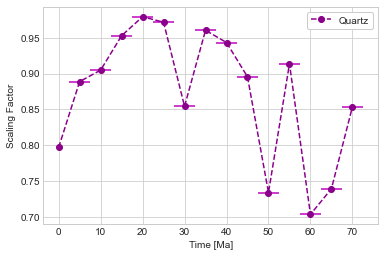

In [418]:
plt.style.use('seaborn-whitegrid')

if system == 1: 
    plt.plot(time, SiteHe_qtz, 'o--', color = 'darkmagenta', label = 'Quartz')
    plt.errorbar(time[0],SiteHe_qtz[0], yerr=None, xerr = xerr2, ecolor = 'm' ,ls = 'none')
    plt.errorbar(time[1::],SiteHe_qtz[1::],yerr=None, xerr = 2.5, ecolor = 'm' ,ls = 'none')

if system == 2: 
    plt.plot(time,SiteHe_cpx,'o--', color = 'blue', label = 'Pyroxene')
    plt.errorbar(time[0],SiteHe_cpx[0], yerr=None, xerr = xerr2, ecolor = 'b' ,ls = 'none')
    plt.errorbar(time[1::],SiteHe_cpx[1::],yerr=None, xerr = 2.5, ecolor = 'b' ,ls = 'none')

if system == 3: 
    plt.plot(time,SiteHe_ol,'o--', color = 'green', label = 'Olivine')
    plt.errorbar(time[0],SiteHe_ol[0], yerr=None, xerr = xerr2, ecolor = 'g' ,ls = 'none')
    plt.errorbar(time[1::],SiteHe_ol[1::],yerr=None, xerr = 2.5, ecolor = 'g' ,ls = 'none')

plt.xlabel('Time [Ma]')
plt.ylabel('Scaling Factor')
plt.legend(frameon = True,facecolor='white',framealpha=1)

#plt.savefig('sf_vs_time.png' , dpi = 300, bbox_inches = 'tight')
